In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


Mounted at /content/drive


## Preprocessing

In [ ]:
data_file_path = '../data/censusbureau.data'
columns_file_path = '../data/census-bureau.columns'
with open(columns_file_path, 'r') as f:
    columns = [line.strip() for line in f if line.strip()]
df = pd.read_csv(data_file_path, header=None)
df.columns = columns

target = 'label'
weight_column = 'weight'
continuous_columns = ['age','wage per hour','capital gains','capital losses','dividends from stocks','num persons worked for employer','weeks worked in year']
categorical_columns = [col for col in df.columns if col not in continuous_columns + [target,weight_column]]
df['label'] = df['label'].map({'- 50000.': 0, '50000+.': 1})
df['hispanic origin'] = df['hispanic origin'].fillna('Do not know')
df[categorical_columns] = df[categorical_columns].replace('?', np.nan)
education_rank = {
    'Children': 1,
    'Less than 1st grade': 2,
    '1st 2nd 3rd or 4th grade': 3,
    '5th or 6th grade': 4,
    '7th and 8th grade': 5,
    '9th grade': 6,
    '10th grade': 7,
    '11th grade': 8,
    '12th grade no diploma': 9,
    'High school graduate': 10,
    'Some college but no degree': 11,
    'Associates degree-occup /vocational': 12,
    'Associates degree-academic program': 13,
    'Bachelors degree(BA AB BS)': 14,
    'Masters degree(MA MS MEng MEd MSW MBA)': 15,
    'Prof school degree (MD DDS DVM LLB JD)': 16,
    'Doctorate degree(PhD EdD)': 17
}
df['education'] = df['education'].map(education_rank)
categorical_columns.remove('education')
continuous_columns.append('education')

In [4]:
for col in categorical_columns:
    df[col] = df[col].fillna('Unknown')

In [5]:
# ENCODING categorical features

ohe_categorical_columns = ['class of worker','enroll in edu inst last wk','marital stat','major occupation code','race','hispanic origin','member of a labor union','reason for unemployment','full or part time employment stat','tax filer stat','region of previous residence','detailed household summary in household','migration code-change in msa','migration code-change in reg','migration code-move within reg','live in this house 1 year ago','migration prev res in sunbelt','family members under 18','citizenship','own business or self employed','fill inc questionnaire for veteran\'s admin','veterans benefits','sex','year']
target_encode_columns = ['detailed industry recode','detailed occupation recode','major industry code','state of previous residence','detailed household and family stat','country of birth father','country of birth mother','country of birth self']


df2 = pd.get_dummies(df, columns=ohe_categorical_columns, drop_first=False, dtype=int)

for col in target_encode_columns:
    mean_target = df2.groupby(col)['label'].mean()
    rank_map = mean_target.rank(method='dense').astype(int)
    df2[col] = df2[col].map(rank_map)

In [6]:
# Adding Derived features
df2['has_capital_income'] = ((df2['capital gains'] > 0) | (df2['dividends from stocks'] > 0)).astype(int)
df2['is_working'] = (df2['weeks worked in year'] > 0).astype(int)
df2['hourly_earnings_proxy'] = df2['wage per hour'] * df2['weeks worked in year']  # rough annual wage
df2['foreign_born'] = (df2['country of birth self'] != 'United States').astype(int)

In [7]:
X = df2.drop(columns=['label', 'weight'])
X_weight = df2['weight']

In [8]:
X.shape

(199523, 164)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## PCA

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.85)
X_pca = pca.fit_transform(X_scaled)

In [13]:
X_pca.shape

(199523, 71)

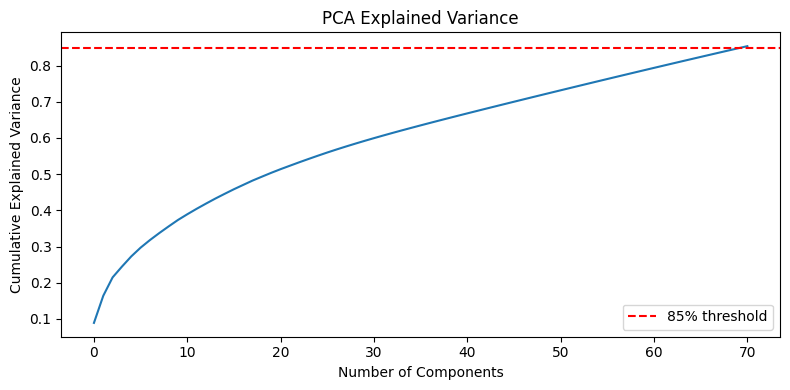

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(0.85, color='red', linestyle='--', label='85% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()

## Kmeans - Elbow

In [17]:
inertias = []
silhouettes = []
K_range = range(2, 11)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in K_range:
    km = KMeans(n_clusters=k, random_state=121, n_init=10)  # k-means++ is actually default but explicit here
    labels = km.fit_predict(X_pca, sample_weight=X_weight)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_pca, labels, sample_size=5000, random_state=42))
    print(f"k={k} | silhouette={silhouettes[-1]:.4f}")

k=2 | silhouette=0.1220
k=3 | silhouette=0.1361
k=4 | silhouette=0.1169
k=5 | silhouette=0.1401
k=6 | silhouette=0.1407
k=7 | silhouette=0.1476
k=8 | silhouette=0.1030
k=9 | silhouette=0.1174
k=10 | silhouette=0.1280


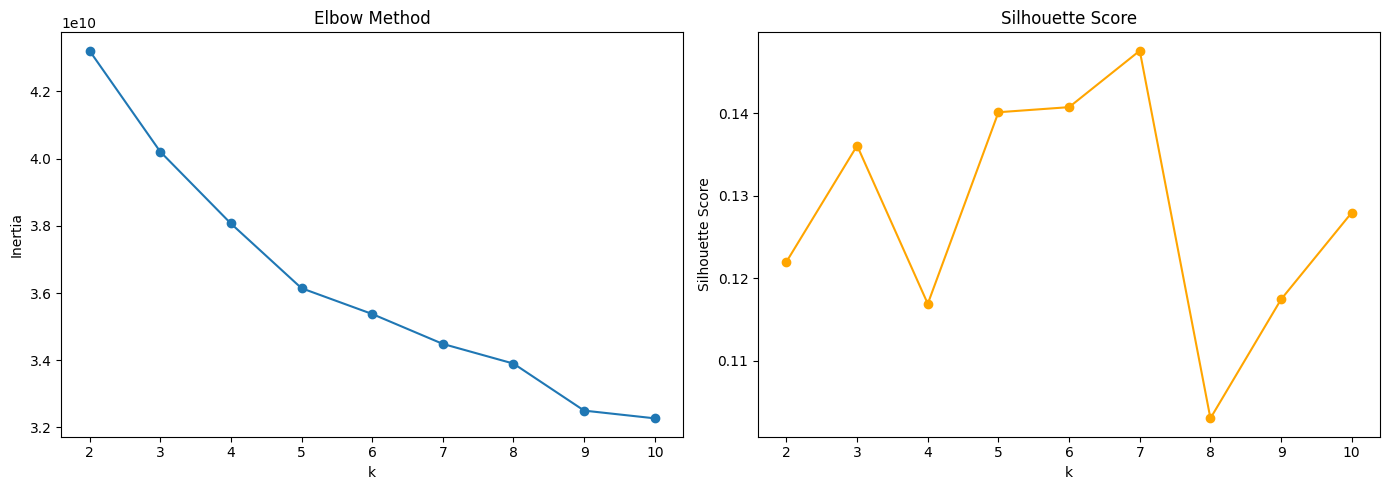

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')

axes[1].plot(K_range, silhouettes, marker='o', color='orange')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

## GMM

In [21]:
from sklearn.mixture import GaussianMixture

bics = []
aics = []
silhouettes_gmm = []

for k in range(2,11):
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    gmm.fit(X_pca)
    labels = gmm.predict(X_pca)


    bics.append(gmm.bic(X_pca))
    aics.append(gmm.aic(X_pca))
    silhouettes_gmm.append(silhouette_score(X_pca, labels, sample_size=5000, random_state=42))
    print(f"k={k} \n BIC={bics[-1]:.0f} \n AIC={aics[-1]:.0f} \n silhouette={silhouettes_gmm[-1]:.4f}")

k=2 
 BIC=18857511 
 AIC=18803891 
 silhouette=0.1094
k=3 
 BIC=12674233 
 AIC=12593797 
 silhouette=0.1259
k=4 
 BIC=2913760 
 AIC=2806509 
 silhouette=0.1342
k=5 
 BIC=-13712789 
 AIC=-13846856 
 silhouette=0.1268
k=6 
 BIC=-17735550 
 AIC=-17896432 
 silhouette=0.1219
k=7 
 BIC=-28312880 
 AIC=-28500576 
 silhouette=0.0861
k=8 
 BIC=-28850527 
 AIC=-29065039 
 silhouette=0.0801
k=9 
 BIC=-30301613 
 AIC=-30542941 
 silhouette=0.0940
k=10 
 BIC=-31815578 
 AIC=-32083720 
 silhouette=0.1090


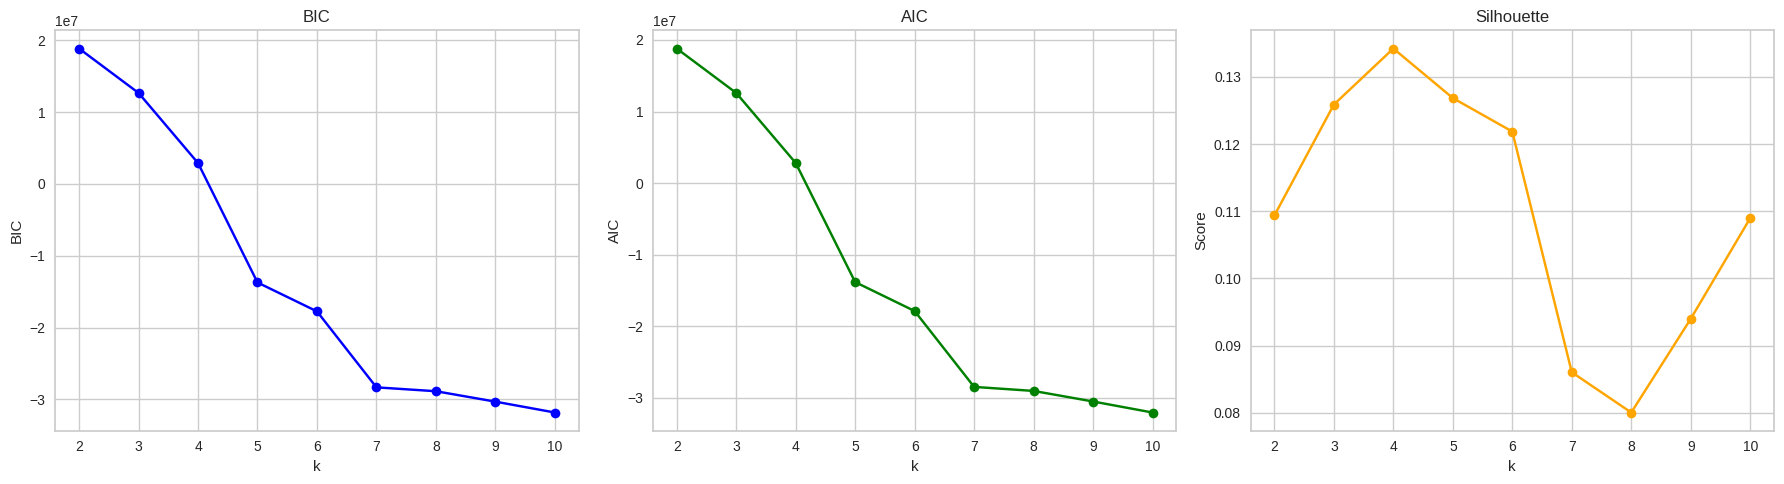

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(range(2,11), bics, marker='o', color='blue')
axes[0].set_title('BIC')
axes[0].set_xlabel('k')
axes[0].set_ylabel('BIC')

axes[1].plot(range(2,11), aics, marker='o', color='green')
axes[1].set_title('AIC')
axes[1].set_xlabel('k')
axes[1].set_ylabel('AIC')

axes[2].plot(range(2,11), silhouettes_gmm, marker='o', color='orange')
axes[2].set_title('Silhouette')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

## Final Model: Kmeans with k = 6

In [14]:
# Final Model Kmeans with k = 6
from sklearn.cluster import KMeans
km_final = KMeans(n_clusters=6, random_state=121,n_init=10)
df2['segment'] = km_final.fit_predict(X_pca)
print(df2['segment'].value_counts().sort_index())

segment
0    61401
1    26839
2    46269
3    49241
4      530
5    15243
Name: count, dtype: int64


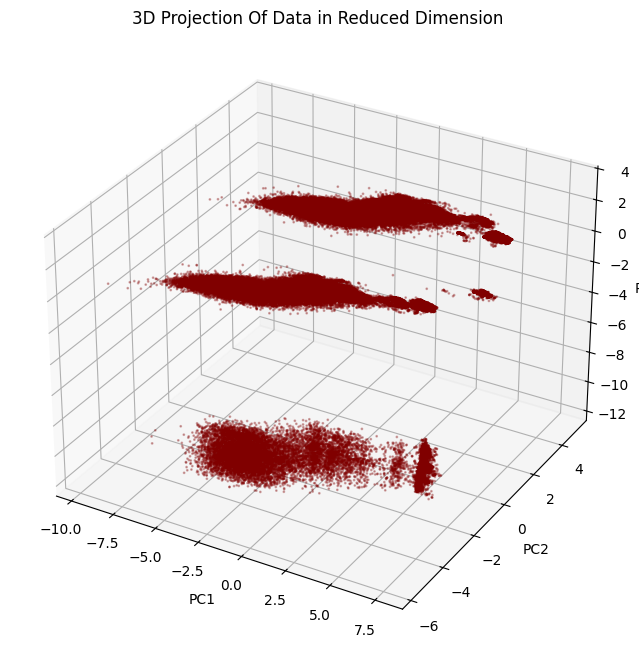

In [16]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Plot
x = X_pca_3d[:, 0]
y = X_pca_3d[:, 1]
z = X_pca_3d[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c="maroon", marker="o", alpha=0.3, s=1)
ax.set_title("3D Projection Of Data in Reduced Dimension")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

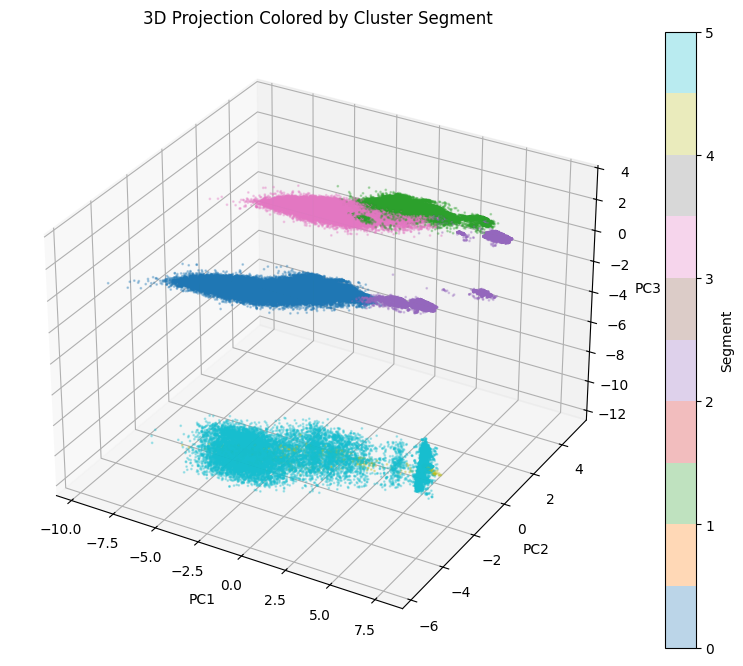

In [21]:
# Color by cluster segment on 3 component PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(x, y, z, c=df2['segment'], cmap='tab10', marker="o", alpha=0.3, s=1)
plt.colorbar(scatter, label='Segment')
ax.set_title("3D Projection Colored by Cluster Segment")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

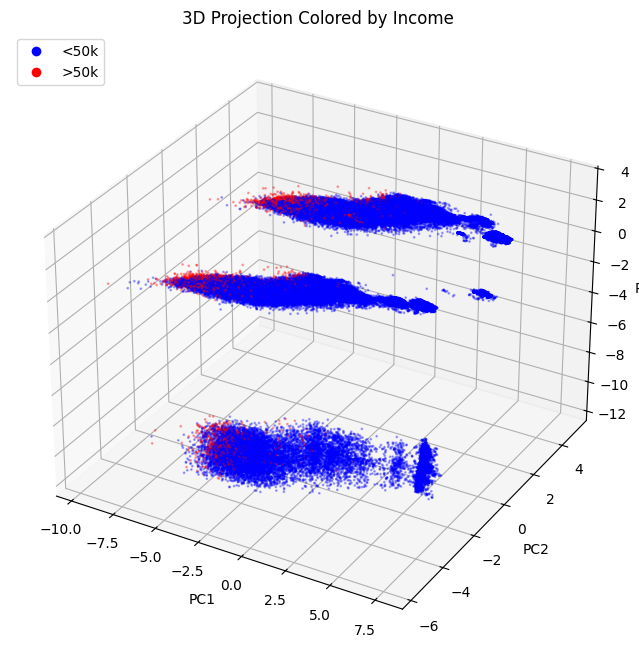

In [30]:
# Color by cluster segment on 3 component PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
colors = df['label'].map({0: 'blue', 1: 'red'})

scatter = ax.scatter(x, y, z, color=colors, marker="o", alpha=0.3, s=1)
ax.set_title("3D Projection Colored by Income")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='<50k'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='>50k')
]
ax.legend(handles=legend_elements, loc='upper left')

plt.show()

## Customer Profiling

In [17]:
df['segment'] = df2['segment']

In [18]:
df.segment.value_counts()

,count
segment,
0,61401
3,49241
2,46269
1,26839
5,15243
4,530


In [19]:
df.groupby('segment')['label'].mean()

,label
segment,
0,0.085031
1,0.016767
2,0.000000
3,0.123738
4,0.033962
5,0.039362


In [20]:
df.columns

Index(['age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household', 'weight',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'ow

In [21]:
df_working = df[~df['full or part time employment stat'].isin(['Children or Armed Forces', 'Not in labor force'])]
df_working = df_working[df_working['age'] > 16]
print(df_working['segment'].value_counts().sort_index())

segment
1      231
2        6
3    48006
Name: count, dtype: int64


In [22]:
df['num persons worked for employer'] = df['num persons worked for employer'].astype(int)

In [23]:
cont_profile = df.groupby('segment')[continuous_columns+['label']].mean().round(2)
print("=== CONTINUOUS PROFILE ===")
print(cont_profile.T)

=== CONTINUOUS PROFILE ===
segment                               0       1     2       3       4       5
age                               45.87   51.22  7.51   38.74   28.21   27.63
wage per hour                     75.86    0.02  0.00  113.48   24.81   52.47
capital gains                    592.76  219.35  0.04  810.50  237.21  289.71
capital losses                    51.54   23.21  0.16   62.95   32.59   34.94
dividends from stocks            292.17  345.38  0.19  219.37  188.97   84.74
num persons worked for employer    2.53    0.55  0.02    3.75    1.53    2.23
weeks worked in year              31.08    3.39  0.07   45.33   14.70   25.01
education                         10.39    8.97  1.30   11.01    8.19    8.16
label                              0.09    0.02  0.00    0.12    0.03    0.04


In [34]:
high_card = ['major occupation code', 'major industry code', 'full or part time employment stat', 'tax filer stat','detailed household summary in household']

print("=== TOP 3 VALUES PER SEGMENT ===")
for col in high_card:
    print(f"\n{'='*50}")
    print(f"{col}")
    print('='*50)
    for seg in sorted(df['segment'].unique()):
        sub = df[df['segment'] == seg]
        top3 = sub[col].value_counts(normalize=True).head(3) * 100
        print(f"\nSegment {seg}:")
        print(top3.round(1))

=== TOP 3 VALUES PER SEGMENT ===

major occupation code

Segment 0:
major occupation code
Not in universe                   33.9
Adm support including clerical    10.1
Professional specialty             9.3
Name: proportion, dtype: float64

Segment 1:
major occupation code
Not in universe    98.7
Other service       0.5
Sales               0.2
Name: proportion, dtype: float64

Segment 2:
major occupation code
Not in universe               99.8
Other service                  0.1
Private household services     0.0
Name: proportion, dtype: float64

Segment 3:
major occupation code
Adm support including clerical    15.0
Professional specialty            14.4
Executive admin and managerial    12.9
Name: proportion, dtype: float64

Segment 4:
major occupation code
Not in universe           59.6
Professional specialty     6.2
Other service              6.0
Name: proportion, dtype: float64

Segment 5:
major occupation code
Not in universe                   44.0
Other service                   

In [36]:
print("=== SEGMENT SIZE & INCOME ===")
overview = df.groupby('segment').agg(
    count=('age', 'count'),
    pct_of_total=('age', lambda x: round(len(x)/len(df)*100, 1)),
    pct_high_income=('label', lambda x: round(x.mean()*100, 1)),
    weighted_count=('weight', 'sum')
).round(2)
print(overview)


=== SEGMENT SIZE & INCOME ===
         count  pct_of_total  pct_high_income  weighted_count
segment                                                      
0        61401          30.8              8.5    1.067487e+08
1        26839          13.5              1.7    4.684069e+07
2        46269          23.2              0.0    7.700684e+07
3        49241          24.7             12.4    8.802761e+07
4          530           0.3              3.4    9.008612e+05
5        15243           7.6              3.9    2.772115e+07


In [37]:
print("=== COUNTRY OF BIRTH SELF — TOP 3 PER SEGMENT ===")
for seg in sorted(df['segment'].unique()):
    sub = df[df['segment'] == seg]
    print(f"\nSegment {seg}:")
    print(sub['country of birth self'].value_counts(normalize=True).head(3).mul(100).round(1))

print("\n=== CITIZENSHIP — DISTRIBUTION PER SEGMENT ===")
citizenship_dist = pd.crosstab(df['segment'], df['citizenship'], normalize='index').mul(100).round(1)
print(citizenship_dist)

=== COUNTRY OF BIRTH SELF — TOP 3 PER SEGMENT ===

Segment 0:
country of birth self
United-States    87.5
Mexico            2.9
Unknown           1.8
Name: proportion, dtype: float64

Segment 1:
country of birth self
United-States    85.0
Mexico            3.5
Unknown           2.4
Name: proportion, dtype: float64

Segment 2:
country of birth self
United-States    95.4
Mexico            1.4
Unknown           0.7
Name: proportion, dtype: float64

Segment 3:
country of birth self
United-States    86.8
Mexico            3.5
Unknown           2.0
Name: proportion, dtype: float64

Segment 4:
country of birth self
United-States    25.1
Mexico           20.6
Unknown          14.5
Name: proportion, dtype: float64

Segment 5:
country of birth self
United-States    88.0
Mexico            3.9
Unknown           1.6
Name: proportion, dtype: float64

=== CITIZENSHIP — DISTRIBUTION PER SEGMENT ===
citizenship  Foreign born- Not a citizen of U S   \
segment                                            


In [38]:
print("=== VETERANS BENEFITS PER SEGMENT ===")
vet_dist = pd.crosstab(df['segment'], df['veterans benefits'], normalize='index').mul(100).round(1)
print(vet_dist)

print("\n=== LABOR UNION MEMBERSHIP PER SEGMENT ===")
union_dist = pd.crosstab(df['segment'], df['member of a labor union'], normalize='index').mul(100).round(1)
print(union_dist)

=== VETERANS BENEFITS PER SEGMENT ===
veterans benefits     0    1     2
segment                           
0                   0.0  1.4  98.6
1                   0.0  2.3  97.7
2                  94.4  0.0   5.6
3                   0.0  0.8  99.2
4                  18.3  0.2  81.5
5                  23.8  0.7  75.5

=== LABOR UNION MEMBERSHIP PER SEGMENT ===
member of a labor union    No  Not in universe  Yes
segment                                            
0                        10.8             87.0  2.2
1                         0.0            100.0  0.0
2                         0.0            100.0  0.0
3                        16.3             80.7  3.0
4                         6.6             93.4  0.0
5                         8.8             90.0  1.1


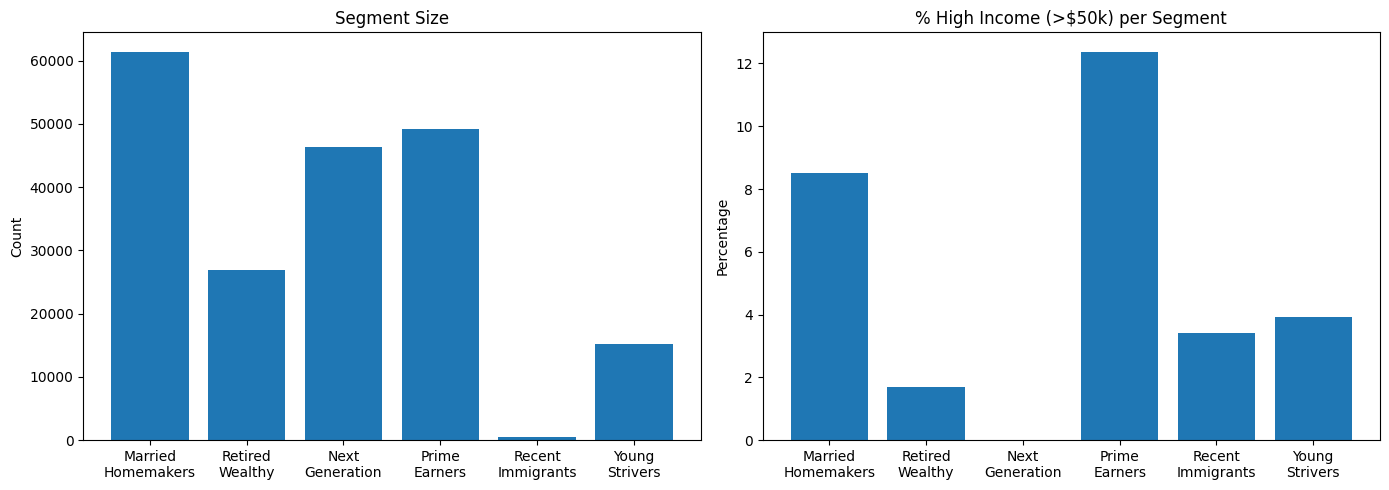

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Segment sizes
segment_names = {0: 'Married\nHomemakers', 1: 'Retired\nWealthy',
                 2: 'Next\nGeneration', 3: 'Prime\nEarners',
                 4: 'Recent\nImmigrants', 5: 'Young\nStrivers'}

sizes = df['segment'].value_counts().sort_index()
axes[0].bar(segment_names.values(), sizes.values)
axes[0].set_title('Segment Size')
axes[0].set_ylabel('Count')

# High income rate
income_rate = df.groupby('segment')['label'].mean() * 100
axes[1].bar(segment_names.values(), income_rate.values)
axes[1].set_title('% High Income (>$50k) per Segment')
axes[1].set_ylabel('Percentage')

plt.tight_layout()
plt.show()

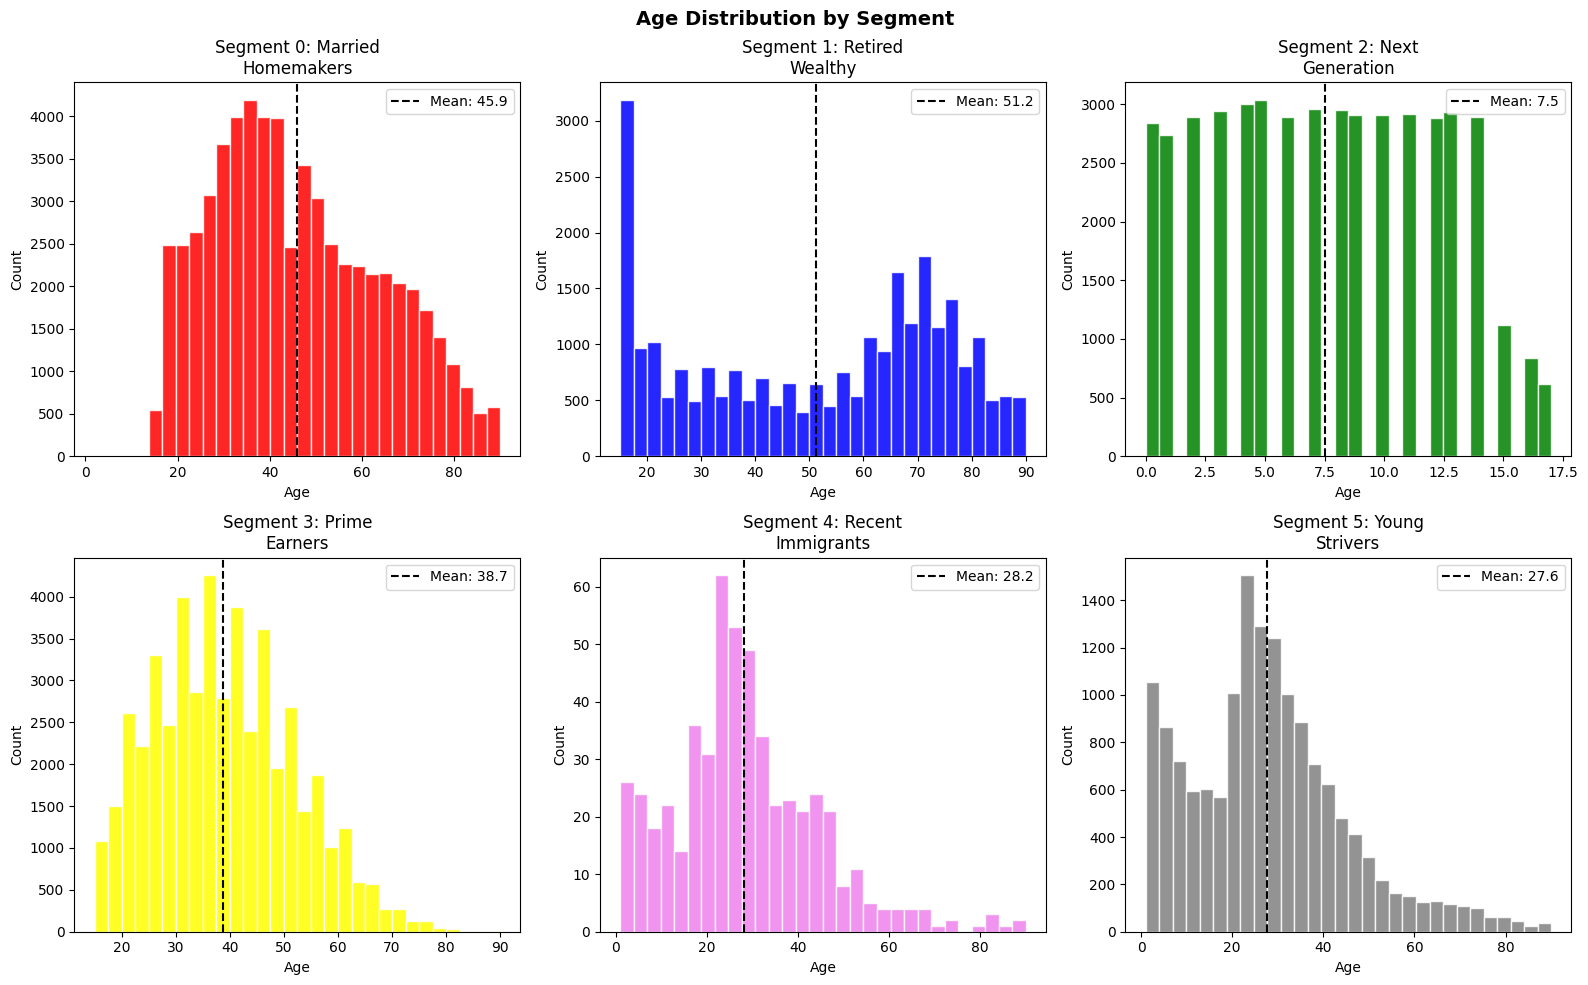

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
colors = ['red','blue','green','yellow','violet','gray']

for i, (seg, name) in enumerate(segment_names.items()):
    sub = df[df['segment'] == seg]
    axes[i].hist(sub['age'], bins=30, color=colors[i], edgecolor='white', alpha=0.85)
    axes[i].set_title(f'Segment {seg}: {name}')
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Count')
    axes[i].axvline(sub['age'].mean(), color='black', linestyle='--',label=f'Mean: {sub["age"].mean():.1f}')
    axes[i].legend()

plt.suptitle('Age Distribution by Segment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

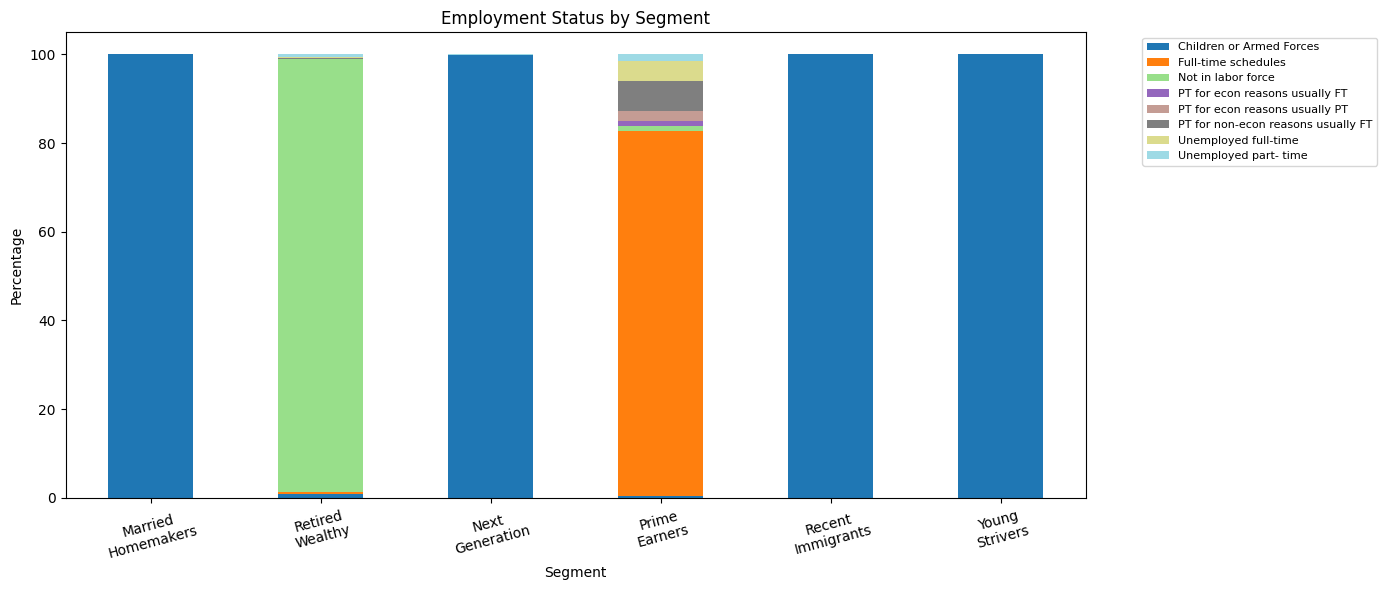

In [42]:
emp_dist = pd.crosstab(df['segment'], df['full or part time employment stat'], normalize='index') * 100
emp_dist.index = segment_names.values()
emp_dist.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab20')
plt.title('Employment Status by Segment')
plt.xlabel('Segment')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

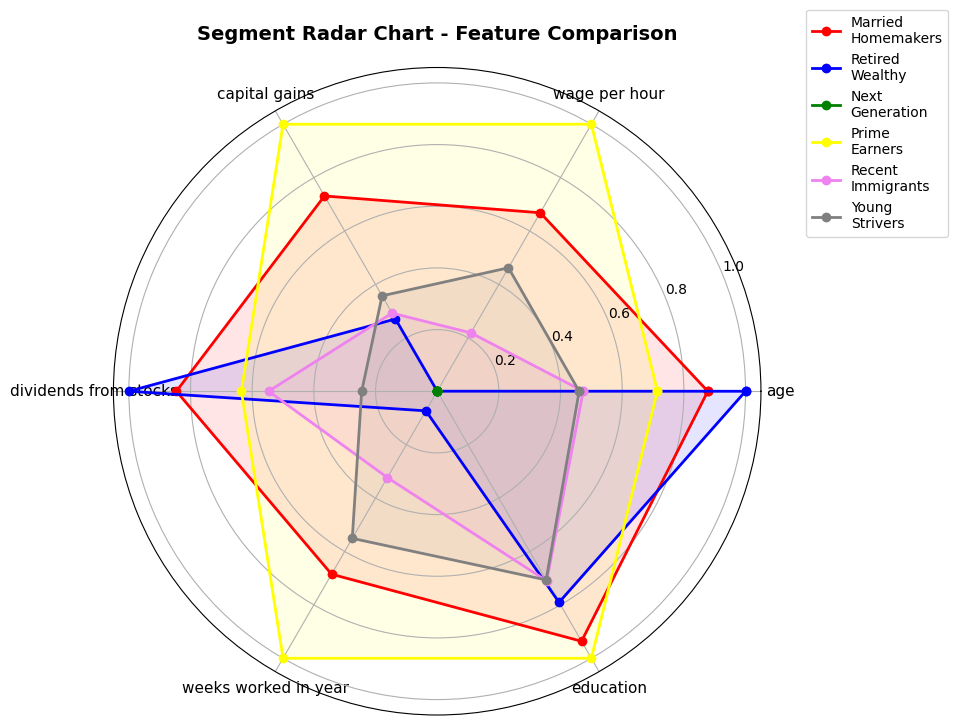

In [30]:
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Normalization
features = ['age', 'wage per hour', 'capital gains', 'dividends from stocks', 'weeks worked in year', 'education']

profile = df.groupby('segment')[features].mean()
normalized = (profile - profile.min()) / (profile.max() - profile.min())

# Number of variables
N = len(features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
colors = ['red','blue','green','yellow','violet','gray']

for i, (seg, name) in enumerate(segment_names.items()):
    values = normalized.loc[seg].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, size=11)
ax.set_title('Segment Radar Chart - Feature Comparison', size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

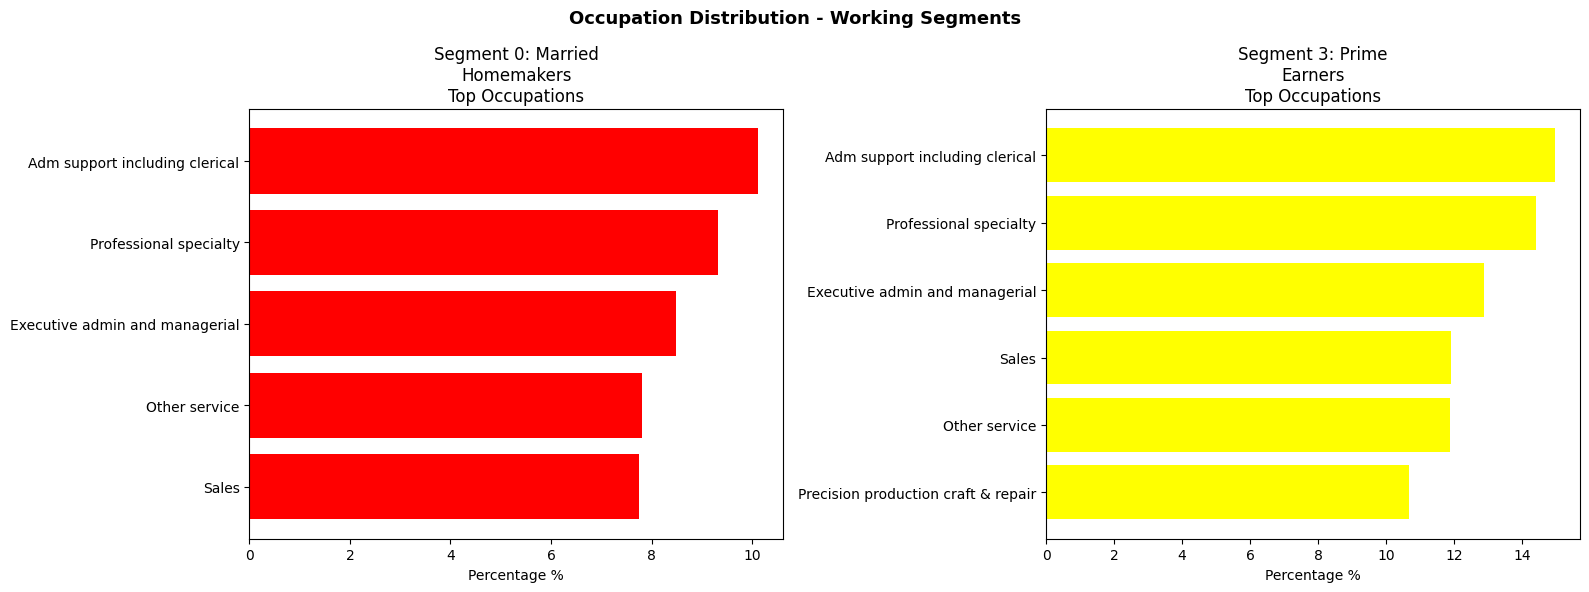

In [29]:
# Focus on segments 0 and 3 — the two working segments
working_segs = df[df['segment'].isin([0, 3])]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, seg in enumerate([0, 3]):
    sub = working_segs[working_segs['segment'] == seg]
    top_occ = sub['major occupation code'].value_counts(normalize=True).head(6) * 100
    top_occ = top_occ[top_occ.index != 'Not in universe']
    axes[i].barh(top_occ.index, top_occ.values, color=colors[seg])
    axes[i].set_title(f'Segment {seg}: {segment_names[seg]}\nTop Occupations')
    axes[i].set_xlabel('Percentage %')
    axes[i].invert_yaxis()

plt.suptitle('Occupation Distribution - Working Segments', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()